# Задание 6: Рекуррентные нейронные сети (RNNs)

Это задание адаптиповано из Deep NLP Course at ABBYY (https://github.com/DanAnastasyev/DeepNLP-Course) с разрешения автора - Даниила Анастасьева. Спасибо ему огромное!

In [ ]:
!pip3 -qq install torch==0.4.1
!pip3 -qq install bokeh==0.13.0
!pip3 -qq install gensim==3.6.0
!pip3 -qq install nltk
!pip3 -qq install scikit-learn==0.20.2

     |████████████████████████████████| 519.5MB 30kB/s 
ERROR: torchvision 0.6.0+cu101 has requirement torch==1.5.0, but you'll have torch 0.4.1 which is incompatible.
ERROR: fastai 1.0.60 has requirement torch>=1.0.0, but you'll have torch 0.4.1 which is incompatible.
     |████████████████████████████████| 16.0MB 214kB/s 
     |████████████████████████████████| 5.4MB 113kB/s 


In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


if torch.cuda.is_available():
    from torch.cuda import FloatTensor, LongTensor
else:
    from torch import FloatTensor, LongTensor

np.random.seed(42)

# Рекуррентные нейронные сети (RNNs)

## POS Tagging

Мы рассмотрим применение рекуррентных сетей к задаче sequence labeling (последняя картинка).

![RNN types](http://karpathy.github.io/assets/rnn/diags.jpeg)

*From [The Unreasonable Effectiveness of Recurrent Neural Networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)*

Самые популярные примеры для такой постановки задачи - Part-of-Speech Tagging и Named Entity Recognition.

Мы порешаем сейчас POS Tagging для английского.

Будем работать с таким набором тегов:
- ADJ - adjective (new, good, high, ...)
- ADP - adposition (on, of, at, ...)
- ADV - adverb (really, already, still, ...)
- CONJ - conjunction (and, or, but, ...)
- DET - determiner, article (the, a, some, ...)
- NOUN - noun (year, home, costs, ...)
- NUM - numeral (twenty-four, fourth, 1991, ...)
- PRT - particle (at, on, out, ...)
- PRON - pronoun (he, their, her, ...)
- VERB - verb (is, say, told, ...)
- . - punctuation marks (. , ;)
- X - other (ersatz, esprit, dunno, ...)

Скачаем данные:

In [ ]:
import nltk
from sklearn.model_selection import train_test_split

nltk.download('brown')
nltk.download('universal_tagset')

data = nltk.corpus.brown.tagged_sents(tagset='universal')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


Пример размеченного предложения:

In [ ]:
for word, tag in data[0]:
    print('{:15}\t{}'.format(word, tag))

The            	DET
Fulton         	NOUN
County         	NOUN
Grand          	ADJ
Jury           	NOUN
said           	VERB
Friday         	NOUN
an             	DET
investigation  	NOUN
of             	ADP
Atlanta's      	NOUN
recent         	ADJ
primary        	NOUN
election       	NOUN
produced       	VERB
``             	.
no             	DET
evidence       	NOUN
''             	.
that           	ADP
any            	DET
irregularities 	NOUN
took           	VERB
place          	NOUN
.              	.


Построим разбиение на train/val/test - наконец-то, всё как у нормальных людей.

На train будем учиться, по val - подбирать параметры и делать всякие early stopping, а на test - принимать модель по ее финальному качеству.

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.15, random_state=42)

print('Words count in train set:', sum(len(sent) for sent in train_data))
print('Words count in val set:', sum(len(sent) for sent in val_data))
print('Words count in test set:', sum(len(sent) for sent in test_data))

Words count in train set: 739769
Words count in val set: 130954
Words count in test set: 290469


Построим маппинги из слов в индекс и из тега в индекс:


In [ ]:
words = {word for sample in train_data for word, tag in sample}
word2ind = {word: ind + 1 for ind, word in enumerate(words)}
word2ind['<pad>'] = 0

tags = {tag for sample in train_data for word, tag in sample}
tag2ind = {tag: ind + 1 for ind, tag in enumerate(tags)}
tag2ind['<pad>'] = 0

print('Unique words in train = {}. Tags = {}'.format(len(word2ind), tags))

Unique words in train = 45441. Tags = {'NUM', 'PRT', 'ADP', 'ADJ', '.', 'DET', 'VERB', 'ADV', 'X', 'CONJ', 'NOUN', 'PRON'}


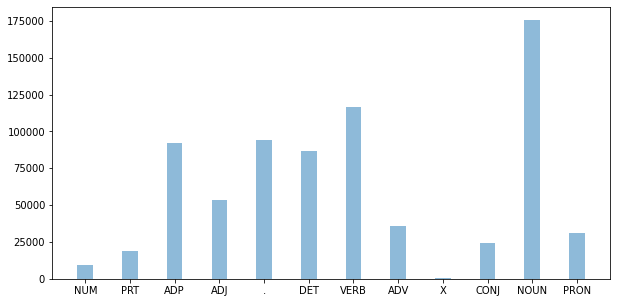

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

tag_distribution = Counter(tag for sample in train_data for _, tag in sample)
tag_distribution = [tag_distribution[tag] for tag in tags]

plt.figure(figsize=(10, 5))

bar_width = 0.35
plt.bar(np.arange(len(tags)), tag_distribution, bar_width, align='center', alpha=0.5)
plt.xticks(np.arange(len(tags)), tags)
    
plt.show()

## Бейзлайн

Какой самый простой теггер можно придумать? Давайте просто запоминать, какие теги самые вероятные для слова (или для последовательности):

![tag-context](https://www.nltk.org/images/tag-context.png)  
*From [Categorizing and Tagging Words, nltk](https://www.nltk.org/book/ch05.html)*

На картинке показано, что для предсказания $t_n$ используются два предыдущих предсказанных тега + текущее слово. По корпусу считаются вероятность для $P(t_n| w_n, t_{n-1}, t_{n-2})$, выбирается тег с максимальной вероятностью.

Более аккуратно такая идея реализована в Hidden Markov Models: по тренировочному корпусу вычисляются вероятности $P(w_n| t_n), P(t_n|t_{n-1}, t_{n-2})$ и максимизируется их произведение.

Простейший вариант - униграммная модель, учитывающая только слово:

In [ ]:
import nltk

default_tagger = nltk.DefaultTagger('NN')

unigram_tagger = nltk.UnigramTagger(train_data, backoff=default_tagger)
print('Accuracy of unigram tagger = {:.2%}'.format(unigram_tagger.evaluate(test_data)))

Accuracy of unigram tagger = 92.62%


Добавим вероятности переходов:

In [ ]:
bigram_tagger = nltk.BigramTagger(train_data, backoff=unigram_tagger)
print('Accuracy of bigram tagger = {:.2%}'.format(bigram_tagger.evaluate(test_data)))

Accuracy of bigram tagger = 93.42%


Обратите внимание, что `backoff` важен:

In [ ]:
trigram_tagger = nltk.TrigramTagger(train_data)
print('Accuracy of trigram tagger = {:.2%}'.format(trigram_tagger.evaluate(test_data)))

Accuracy of trigram tagger = 23.33%


## Увеличиваем контекст с рекуррентными сетями

Униграмная модель работает на удивление хорошо, но мы же собрались учить сеточки.

Омонимия - основная причина, почему униграмная модель плоха:  
*“he cashed a check at the **bank**”*  
vs  
*“he sat on the **bank** of the river”*

Поэтому нам очень полезно учитывать контекст при предсказании тега.

Воспользуемся LSTM - он умеет работать с контекстом очень даже хорошо:

![](https://image.ibb.co/kgmoff/Baseline-Tagger.png)

Синим показано выделение фичей из слова, LSTM оранжевенький - он строит эмбеддинги слов с учетом контекста, а дальше зелененькая логистическая регрессия делает предсказания тегов.

In [ ]:
def convert_data(data, word2ind, tag2ind):
    X = [[word2ind.get(word, 0) for word, _ in sample] for sample in data]
    y = [[tag2ind[tag] for _, tag in sample] for sample in data]
    
    return X, y

X_train, y_train = convert_data(train_data, word2ind, tag2ind)
X_val, y_val = convert_data(val_data, word2ind, tag2ind)
X_test, y_test = convert_data(test_data, word2ind, tag2ind)

In [ ]:
def iterate_batches(data, batch_size):
    X, y = data
    n_samples = len(X)

    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_indices = indices[start:end]
        
        max_sent_len = max(len(X[ind]) for ind in batch_indices)
        X_batch = np.zeros((max_sent_len, len(batch_indices)))
        y_batch = np.zeros((max_sent_len, len(batch_indices)))
        
        for batch_ind, sample_ind in enumerate(batch_indices):
            X_batch[:len(X[sample_ind]), batch_ind] = X[sample_ind]
            y_batch[:len(y[sample_ind]), batch_ind] = y[sample_ind]
            
        yield X_batch, y_batch

In [ ]:
X_batch, y_batch = next(iterate_batches((X_train, y_train), 4))

X_batch.shape, y_batch.shape

((32, 4), (32, 4))

**Задание** Реализуйте `LSTMTagger`:

In [ ]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1, verbose=False):
        super().__init__()
        self.verbose = verbose
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=word_emb_dim)
        self.lstm = nn.LSTM(input_size=word_emb_dim, hidden_size=lstm_hidden_dim, num_layers=lstm_layers_count)
        self.linear = nn.Linear(in_features=lstm_hidden_dim, out_features=tagset_size)    

    def forward(self, inputs):
        if self.verbose:
            print(f'Input shape: {inputs.shape}')
            
        embedding_out = self.embedding(inputs)
        if self.verbose:
            print(f'Embedding shape: {embedding_out.shape}')
        
        lstm_out, _ = self.lstm(embedding_out)
        if self.verbose:
            print(f'LSTM output shape: {lstm_out.shape}')
        
        linear_out = self.linear(lstm_out)
        if self.verbose:
            print(f'Prediction shape: {linear_out.shape}')
        
        return linear_out

**Задание** Научитесь считать accuracy и loss (а заодно проверьте, что модель работает)

In [ ]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
)

X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)

logits = model(X_batch)

labels = torch.argmax(logits.view(y_batch.size()[0], y_batch.size()[1], -1), dim=2)  
cur_correct_count, cur_sum_count = float(torch.sum(labels == y_batch)), labels.numel()  #

accuracy = cur_correct_count / cur_sum_count

print(f'\nPrediction shape: {logits.shape}')
print(f'True labels shape: {y_batch.shape}')

print(f'\nAccuracy: {accuracy:.4f}')



Prediction shape: torch.Size([32, 4, 13])
True labels shape: torch.Size([32, 4])

Accuracy: 0.0703


In [ ]:
criterion = nn.CrossEntropyLoss().cuda()
logits_loss = torch.transpose(torch.transpose(logits, 0, 1), 1, 2)
y_batch_loss = torch.transpose(y_batch, 0, 1)
loss = criterion(logits_loss, y_batch_loss)

print(f'Loss: {loss:.4f}')


Loss: 2.5823


**Задание** Вставьте эти вычисление в функцию:

In [ ]:
import math
from tqdm import tqdm


def do_epoch(model, criterion, data, batch_size, optimizer=None, name=None):
    epoch_loss = 0
    correct_count = 0
    sum_count = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = math.ceil(len(data[0]) / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
                X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
                logits = model(X_batch)
                logits_loss = torch.transpose(torch.transpose(logits, 0, 1), 1, 2)
                y_batch_loss = torch.transpose(y_batch, 0, 1)
                loss = criterion(logits_loss, y_batch_loss)

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                #indices = torch.argmax(logits, -1)
                #mask = y_batch.bool().float()
                #match = (indices == y_batch).float()
           
                #cur_correct_count = torch.sum(match * mask)
                #cur_sum_count = torch.sum(mask) 

                labels = torch.argmax(logits.view(y_batch.size()[0], y_batch.size()[1], -1), dim=2)  # my
                cur_correct_count, cur_sum_count = float(torch.sum(labels == y_batch)), labels.numel()  # my

                correct_count += cur_correct_count
                sum_count += cur_sum_count

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                    name, loss.item(), cur_correct_count / cur_sum_count)
                )
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                name, epoch_loss / batches_count, correct_count / sum_count)
            )

    return epoch_loss / batches_count, correct_count / sum_count


def fit(model, criterion, optimizer, train_data, epochs_count=1, batch_size=32,
        val_data=None, val_batch_size=None):
        
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss, train_acc = do_epoch(model, criterion, train_data, batch_size, optimizer, name_prefix + 'Train:')
        
        if not val_data is None:
            val_loss, val_acc = do_epoch(model, criterion, val_data, val_batch_size, None, name_prefix + '  Val:')

In [ ]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss().cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 50] Train: Loss = 0.31355, Accuracy = 91.17%: 100%|██████████| 572/572 [00:05<00:00, 103.24it/s]
[1 / 50]   Val: Loss = 0.10753, Accuracy = 96.97%: 100%|██████████| 13/13 [00:00<00:00, 96.70it/s]
[2 / 50] Train: Loss = 0.10096, Accuracy = 96.84%: 100%|██████████| 572/572 [00:05<00:00, 103.32it/s]
[2 / 50]   Val: Loss = 0.07552, Accuracy = 97.95%: 100%|██████████| 13/13 [00:00<00:00, 95.56it/s]
[3 / 50] Train: Loss = 0.06807, Accuracy = 97.85%: 100%|██████████| 572/572 [00:05<00:00, 103.75it/s]
[3 / 50]   Val: Loss = 0.06918, Accuracy = 98.27%: 100%|██████████| 13/13 [00:00<00:00, 92.03it/s]
[4 / 50] Train: Loss = 0.05103, Accuracy = 98.38%: 100%|██████████| 572/572 [00:05<00:00, 104.29it/s]
[4 / 50]   Val: Loss = 0.06493, Accuracy = 98.45%: 100%|██████████| 13/13 [00:00<00:00, 96.70it/s]
[5 / 50] Train: Loss = 0.04105, Accuracy = 98.69%: 100%|██████████| 572/572 [00:05<00:00, 104.88it/s]
[5 / 50]   Val: Loss = 0.06504, Accuracy = 98.54%: 100%|██████████| 13/13 [00:00<00:00, 98.91i

### Masking

**Задание** Проверьте себя - не считаете ли вы потери и accuracy на паддингах - очень легко получить высокое качество за счет этого.

У функции потерь есть параметр `ignore_index`, для таких целей. Для accuracy нужно использовать маскинг - умножение на маску из нулей и единиц, где нули на позициях паддингов (а потом усреднение по ненулевым позициям в маске).

In [ ]:
def do_epoch(model, criterion, data, batch_size, optimizer=None, name=None):
    epoch_loss = 0
    correct_count = 0
    sum_count = 0
    
    is_train = not optimizer is None
    name = name or ''
    model.train(is_train)
    
    batches_count = math.ceil(len(data[0]) / batch_size)
    
    with torch.autograd.set_grad_enabled(is_train):
        with tqdm(total=batches_count) as progress_bar:
            for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
                X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
                logits = model(X_batch)
                logits_loss = torch.transpose(torch.transpose(logits, 0, 1), 1, 2)
                y_batch_loss = torch.transpose(y_batch, 0, 1)
                loss = criterion(logits_loss, y_batch_loss)

                epoch_loss += loss.item()

                if optimizer:
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                #indices = torch.argmax(logits, -1)
                #mask = y_batch.bool().float()
                #match = (indices == y_batch).float()
           
                #cur_correct_count = torch.sum(match * mask)
                #cur_sum_count = torch.sum(mask) 

                mask = (y_batch != 0)
                labels = torch.argmax(logits.view(y_batch.size()[0], y_batch.size()[1], -1), dim=2)  
                cur_correct_count, cur_sum_count = float(torch.sum((labels == y_batch) * mask)), float(mask.sum())  

                correct_count += cur_correct_count
                sum_count += cur_sum_count

                progress_bar.update()
                progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                    name, loss.item(), cur_correct_count / cur_sum_count)
                )
                
            progress_bar.set_description('{:>5s} Loss = {:.5f}, Accuracy = {:.2%}'.format(
                name, epoch_loss / batches_count, correct_count / sum_count)
            )

    return epoch_loss / batches_count, correct_count / sum_count


def fit(model, criterion, optimizer, train_data, epochs_count=1, batch_size=32,
        val_data=None, val_batch_size=None):
        
    if not val_data is None and val_batch_size is None:
        val_batch_size = batch_size
        
    for epoch in range(epochs_count):
        name_prefix = '[{} / {}] '.format(epoch + 1, epochs_count)
        train_loss, train_acc = do_epoch(model, criterion, train_data, batch_size, optimizer, name_prefix + 'Train:')
        
        if not val_data is None:
            val_loss, val_acc = do_epoch(model, criterion, val_data, val_batch_size, None, name_prefix + '  Val:')

In [ ]:
model = LSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0).cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=10,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 10] Train: Loss = 0.68711, Accuracy = 78.39%: 100%|██████████| 572/572 [00:05<00:00, 102.42it/s]
[1 / 10]   Val: Loss = 0.35221, Accuracy = 88.43%: 100%|██████████| 13/13 [00:00<00:00, 95.19it/s]
[2 / 10] Train: Loss = 0.27316, Accuracy = 90.94%: 100%|██████████| 572/572 [00:05<00:00, 103.93it/s]
[2 / 10]   Val: Loss = 0.23584, Accuracy = 92.38%: 100%|██████████| 13/13 [00:00<00:00, 90.34it/s]
[3 / 10] Train: Loss = 0.18397, Accuracy = 93.91%: 100%|██████████| 572/572 [00:05<00:00, 103.13it/s]
[3 / 10]   Val: Loss = 0.19253, Accuracy = 93.87%: 100%|██████████| 13/13 [00:00<00:00, 92.78it/s]
[4 / 10] Train: Loss = 0.13731, Accuracy = 95.42%: 100%|██████████| 572/572 [00:05<00:00, 103.26it/s]
[4 / 10]   Val: Loss = 0.16903, Accuracy = 94.64%: 100%|██████████| 13/13 [00:00<00:00, 92.94it/s]
[5 / 10] Train: Loss = 0.10662, Accuracy = 96.42%: 100%|██████████| 572/572 [00:05<00:00, 103.82it/s]
[5 / 10]   Val: Loss = 0.15653, Accuracy = 95.00%: 100%|██████████| 13/13 [00:00<00:00, 97.31i

**Задание** Посчитайте качество модели на тесте. Ожидается результат лучше бейзлайна!

In [ ]:
def compute_loss_accuracy(model, criterion, data, batch_size=512):    
    model.eval() # Evaluation mode
    
    with torch.no_grad():    
        loss_accum = 0.0
        correct_count = 0.0
        sum_count = 0.0
        for i, (X_batch, y_batch) in enumerate(iterate_batches(data, batch_size)):
            X_batch, y_batch = LongTensor(X_batch), LongTensor(y_batch)
            logits = model(X_batch)       
            
            logits_loss = torch.transpose(torch.transpose(logits, 0, 1), 1, 2)
            y_batch_loss = torch.transpose(y_batch, 0, 1)
            loss = criterion(logits_loss, y_batch_loss)
            
            loss_accum += loss.item()
            
            mask = (y_batch != 0)
            labels = torch.argmax(logits.view(y_batch.size()[0], y_batch.size()[1], -1), dim=2)  
            cur_correct_count, cur_sum_count = float(torch.sum((labels == y_batch) * mask)), float(mask.sum())  

            correct_count += cur_correct_count
            sum_count += cur_sum_count
    
    return loss_accum / (i + 1), correct_count / sum_count

In [ ]:
test_loss, test_accuracy = compute_loss_accuracy(model, criterion, data=(X_test, y_test))
print('Test: Loss = {:.5f}, Accuracy = {:.2%}'.format(test_loss, test_accuracy))

Test: Loss = 0.16105, Accuracy = 95.49%


### Bidirectional LSTM

Благодаря BiLSTM можно использовать сразу оба контеста при предсказании тега слова. Т.е. для каждого токена $w_i$ forward LSTM будет выдавать представление $\mathbf{f_i} \sim (w_1, \ldots, w_i)$ - построенное по всему левому контексту - и $\mathbf{b_i} \sim (w_n, \ldots, w_i)$ - представление правого контекста. Их конкатенация автоматически захватит весь доступный контекст слова: $\mathbf{h_i} = [\mathbf{f_i}, \mathbf{b_i}] \sim (w_1, \ldots, w_n)$.

![BiLSTM](https://www.researchgate.net/profile/Wang_Ling/publication/280912217/figure/fig2/AS:391505383575555@1470353565299/Illustration-of-our-neural-network-for-POS-tagging.png)  
*From [Finding Function in Form: Compositional Character Models for Open Vocabulary Word Representation](https://arxiv.org/abs/1508.02096)*

**Задание** Добавьте Bidirectional LSTM.

In [ ]:
class BidirectionalLSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, word_emb_dim=100, lstm_hidden_dim=128, lstm_layers_count=1, verbose=False):
        super().__init__()
        self.verbose = verbose
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=word_emb_dim)
        self.lstm = nn.LSTM(input_size=word_emb_dim, hidden_size=lstm_hidden_dim, num_layers=lstm_layers_count, bidirectional=True)
        self.linear = nn.Linear(in_features=2*lstm_hidden_dim, out_features=tagset_size)    

    def forward(self, inputs):
        if self.verbose:
            print(f'Input shape: {inputs.shape}')
            
        embedding_out = self.embedding(inputs)
        if self.verbose:
            print(f'Embedding shape: {embedding_out.shape}')
        
        lstm_out, _ = self.lstm(embedding_out)
        if self.verbose:
            print(f'LSTM output shape: {lstm_out.shape}')
        
        linear_out = self.linear(lstm_out)
        if self.verbose:
            print(f'Prediction shape: {linear_out.shape}')
        
        return linear_out

In [ ]:
model = BidirectionalLSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind),
).cuda()

X_batch, y_batch = torch.LongTensor(X_batch), torch.LongTensor(y_batch)

logits = model(X_batch)

labels = torch.argmax(logits.view(y_batch.size()[0], y_batch.size()[1], -1), dim=2)  
cur_correct_count, cur_sum_count = float(torch.sum(labels == y_batch)), labels.numel()  #

accuracy = cur_correct_count / cur_sum_count

print(f'\nPrediction shape: {logits.shape}')
print(f'True labels shape: {y_batch.shape}')

print(f'\nAccuracy: {accuracy:.4f}')

RuntimeError: ignored

In [ ]:
model = BidirectionalLSTMTagger(
    vocab_size=len(word2ind),
    tagset_size=len(tag2ind),
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0).cuda()
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=10,
    batch_size=64, 
    val_data=(X_val, y_val), 
    val_batch_size=13)


[1 / 10] Train: Loss = 0.55692, Accuracy = 82.31%: 100%|██████████| 572/572 [00:06<00:00, 86.99it/s]
[1 / 10]   Val: Loss = 0.27867, Accuracy = 91.11%: 100%|██████████| 497/497 [00:02<00:00, 233.24it/s]
[2 / 10] Train: Loss = 0.20389, Accuracy = 93.53%: 100%|██████████| 572/572 [00:06<00:00, 86.53it/s]
[2 / 10]   Val: Loss = 0.17986, Accuracy = 94.30%: 100%|██████████| 497/497 [00:02<00:00, 237.05it/s]
[3 / 10] Train: Loss = 0.12894, Accuracy = 96.01%: 100%|██████████| 572/572 [00:06<00:00, 87.79it/s]
[3 / 10]   Val: Loss = 0.14625, Accuracy = 95.39%: 100%|██████████| 497/497 [00:02<00:00, 232.41it/s]
[4 / 10] Train: Loss = 0.08803, Accuracy = 97.31%: 100%|██████████| 572/572 [00:06<00:00, 88.22it/s]
[4 / 10]   Val: Loss = 0.12852, Accuracy = 95.92%: 100%|██████████| 497/497 [00:02<00:00, 241.61it/s]
[5 / 10] Train: Loss = 0.06073, Accuracy = 98.19%: 100%|██████████| 572/572 [00:06<00:00, 88.89it/s]
[5 / 10]   Val: Loss = 0.12396, Accuracy = 96.18%: 100%|██████████| 497/497 [00:02<00:0

In [ ]:
test_loss, test_accuracy = compute_loss_accuracy(model, criterion, data=(X_test, y_test))
print('Test: Loss = {:.5f}, Accuracy = {:.2%}'.format(test_loss, test_accuracy))

Test: Loss = 0.15225, Accuracy = 96.44%


### Предобученные эмбеддинги

Мы знаем, какая клёвая вещь - предобученные эмбеддинги. При текущем размере обучающей выборки еще можно было учить их и с нуля - с меньшей было бы совсем плохо.

Поэтому стандартный пайплайн - скачать эмбеддинги, засунуть их в сеточку. Запустим его:

In [ ]:
import gensim.downloader as api

w2v_model = api.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Построим подматрицу для слов из нашей тренировочной выборки:

In [ ]:
known_count = 0
embeddings = np.zeros((len(word2ind), w2v_model.vectors.shape[1]))
for word, ind in word2ind.items():
    word = word.lower()
    if word in w2v_model.vocab:
        embeddings[ind] = w2v_model.get_vector(word)
        known_count += 1
        
print('Know {} out of {} word embeddings'.format(known_count, len(word2ind)))

Know 38736 out of 45441 word embeddings


In [ ]:

embeddings = torch.FloatTensor(embeddings)

**Задание** Сделайте модель с предобученной матрицей. Используйте `nn.Embedding.from_pretrained`.

In [ ]:
class LSTMTaggerWithPretrainedEmbs(nn.Module):
    def __init__(self, embedding, tagset_size, lstm_hidden_dim=128, lstm_layers_count=1, verbose=False):
        super().__init__()
        self.verbose = verbose
        self.embedding = nn.Embedding.from_pretrained(embedding, freeze = True)
        self.lstm = nn.LSTM(input_size=w2v_model.vectors.shape[1], hidden_size=lstm_hidden_dim, num_layers=lstm_layers_count, bidirectional=True)
        self.linear = nn.Linear(in_features = 2*lstm_hidden_dim, out_features = tagset_size) 


    def forward(self, inputs):
        if self.verbose:
            print(f'Input shape: {inputs.shape}')
            
        embedding_out = self.embedding(inputs)
        if self.verbose:
            print(f'Embedding shape: {embedding_out.shape}')
        
        lstm_out, _ = self.lstm(embedding_out)
        if self.verbose:
            print(f'LSTM output shape: {lstm_out.shape}')
        
        linear_out = self.linear(lstm_out)
        if self.verbose:
            print(f'Prediction shape: {linear_out.shape}')
            
        return linear_out

In [ ]:
model = LSTMTaggerWithPretrainedEmbs(
    embedding=embeddings,
    tagset_size=len(tag2ind)
).cuda()

criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(model.parameters())

fit(model, criterion, optimizer, train_data=(X_train, y_train), epochs_count=50,
    batch_size=64, val_data=(X_val, y_val), val_batch_size=512)

[1 / 50] Train: Loss = 0.47233, Accuracy = 86.04%: 100%|██████████| 572/572 [00:05<00:00, 110.49it/s]
[1 / 50]   Val: Loss = 0.22335, Accuracy = 93.39%: 100%|██████████| 13/13 [00:00<00:00, 73.99it/s]
[2 / 50] Train: Loss = 0.16304, Accuracy = 95.11%: 100%|██████████| 572/572 [00:05<00:00, 112.38it/s]
[2 / 50]   Val: Loss = 0.15881, Accuracy = 95.09%: 100%|██████████| 13/13 [00:00<00:00, 79.89it/s]
[3 / 50] Train: Loss = 0.11651, Accuracy = 96.48%: 100%|██████████| 572/572 [00:05<00:00, 111.98it/s]
[3 / 50]   Val: Loss = 0.12654, Accuracy = 96.04%: 100%|██████████| 13/13 [00:00<00:00, 78.44it/s]
[4 / 50] Train: Loss = 0.09310, Accuracy = 97.17%: 100%|██████████| 572/572 [00:05<00:00, 112.91it/s]
[4 / 50]   Val: Loss = 0.11198, Accuracy = 96.52%: 100%|██████████| 13/13 [00:00<00:00, 79.92it/s]
[5 / 50] Train: Loss = 0.07920, Accuracy = 97.59%: 100%|██████████| 572/572 [00:05<00:00, 110.87it/s]
[5 / 50]   Val: Loss = 0.10512, Accuracy = 96.68%: 100%|██████████| 13/13 [00:00<00:00, 77.73i

**Задание** Оцените качество модели на тестовой выборке. Обратите внимание, вовсе не обязательно ограничиваться векторами из урезанной матрицы - вполне могут найтись слова в тесте, которых не было в трейне и для которых есть эмбеддинги.

Добейтесь качества лучше прошлых моделей.

In [ ]:
test_loss, test_accuracy = compute_loss_accuracy(model, criterion, data=(X_test, y_test))
print('Test: Loss = {:.5f}, Accuracy = {:.2%}'.format(test_loss, test_accuracy))

Test: Loss = 0.21331, Accuracy = 96.82%
